# Example of using Spherical Harmonic Approximation 

This example illustrates the inner workings of the Bluemira spherical harmonics approximation fuction (SHApproximation) which can be used in coilset current and position optimisation for spherical tokamaks. For an example of how SHApproximation is used, please see the notebook called 'Use of Spherical Harmonic Approximation in Optimisation.ipynb'. 

Premise: 

- Our equilibrium solution will not change if the coilset contibution to the poiloidal feild (vacuum feild) is kept the same in the region occupied by the core plasma (i.e. the region characterised by closed fux surfaces).  

- If we constrain the core plasma while altering (optimising) other aspects magnetic conguration, then we will not need to re-solve for the plasma equilibrium at each iteration. 

- We can decopose the vacuum feild into Spherical Harmonics (SH) to create a minimal set of constraints for use in optimisation.

### Imports

In [5]:
# Standard useful
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patch

# Constants
from bluemira.base.constants import MU_0

# Reading data files
# import json

# Grid, coilset and equilibrium
from bluemira.equilibria.coils import Coil, CoilSet
from bluemira.equilibria.equilibrium import Equilibrium

# from bluemira.equilibria.find import find_OX_points
from bluemira.equilibria.harmonics import (
    coil_harmonic_amplitudes,
    coil_harmonic_amplitude_matrix,
    harmonic_amplitude_marix,
    collocation_points,
    lcfs_fit_metric,
)
from bluemira.geometry.coordinates import Coordinates

from scipy.interpolate import RectBivariateSpline
from scipy.special import lpmv

%pdb

Automatic pdb calling has been turned ON


### Equilibria and Coilset Data from File

Note: We cannot use coils that are within the sphere containing the LCFS for our approximation. The maximum radial distance of the LCFS is used as a limit (orange shaded area in plot below). If you have coils in this region then please specify the control coils using a list of the coil names that are outside of the radial limit (this is done automatically in the SHApproximation class).   

One or mpore of your coils is too close to the plamsa to be used in the SH approximation: see plot.


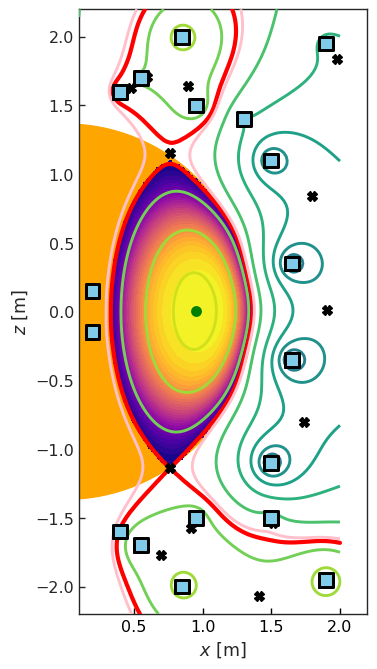

CoilSet(
        Coil(PF_1 ctype=PF x=0.2 z=0.15 dx=0.05 dz=0.05 current=7.6e+03 j_max=nan b_max=nan discretisation=nan)
        Coil(PF_2 ctype=PF x=0.4 z=1.6 dx=0.05 dz=0.05 current=8.2e+04 j_max=nan b_max=nan discretisation=nan)
        Coil(PF_3 ctype=PF x=0.55 z=1.7 dx=0.05 dz=0.05 current=1.9e+04 j_max=nan b_max=nan discretisation=nan)
        Coil(PF_4 ctype=PF x=0.85 z=2 dx=0.05 dz=0.05 current=1.3e+05 j_max=nan b_max=nan discretisation=nan)
        Coil(PF_5 ctype=PF x=0.95 z=1.5 dx=0.05 dz=0.05 current=5.6e+04 j_max=nan b_max=nan discretisation=nan)
        Coil(PF_6 ctype=PF x=1.3 z=1.4 dx=0.05 dz=0.05 current=-1.9e+04 j_max=nan b_max=nan discretisation=nan)
        Coil(PF_7 ctype=PF x=1.5 z=1.1 dx=0.05 dz=0.05 current=-1.1e+05 j_max=nan b_max=nan discretisation=nan)
        Coil(PF_8 ctype=PF x=1.6 z=0.35 dx=0.05 dz=0.05 current=-1.2e+05 j_max=nan b_max=nan discretisation=nan)
        Coil(PF_9 ctype=PF x=1.9 z=1.9 dx=0.05 dz=0.05 current=-1.5e+04 j_max=nan b_max=nan discr

In [6]:
# Data from EQDSK file
file_path = "SH_test_file.json"

# Equilibrium
eq = Equilibrium.from_eqdsk(file_path)

# Profiles
profiles = eq.profiles

# Coilset
coilset = eq.coilset

# Save copy for comparing
starting_eq = deepcopy(eq)
starting_coilset = deepcopy(coilset)

# Grid
grid = eq.grid

# Plasma boundary x and z locations from data file
original_LCFS = eq.get_LCFS()
x_bdry = original_LCFS.x
z_bdry = original_LCFS.z

# Are the coils you have chosen outside the sphere containing the last closed flux surface?
max_bdry_r = np.max(np.sqrt(x_bdry**2 + z_bdry**2))
min_coil_r = np.min(
    np.sqrt(coilset.get_control_coils().x ** 2 + coilset.get_control_coils().x ** 2)
)
if max_bdry_r > min_coil_r:
    print(
        "One or mpore of your coils is too close to the plamsa to be used in the SH approximation: see plot."
    )

# Plot
f, ax = plt.subplots()
eq.plot(ax=ax)
coilset.plot(ax=ax)
ax.set_xlim(np.min(grid.x), np.max(grid.z))
max_circ = patch.Circle((0, 0), max_bdry_r, ec="orange", fill=True, fc="orange")
ax.add_patch(max_circ)
plt.show()

# Look at coilset info
print(eq.coilset)

In [7]:
# Set control coils if nessisary
list_of_cc_names = [
    "PF_2",
    "PF_3",
    "PF_4",
    "PF_5",
    "PF_6",
    "PF_7",
    "PF_8",
    "PF_9",
    "PF_11",
    "PF_12",
    "PF_13",
    "PF_14",
    "PF_15",
    "PF_16",
    "PF_17",
    "PF_18",
]

coilset.control = list_of_cc_names
print(coilset.control)

['PF_2', 'PF_3', 'PF_4', 'PF_5', 'PF_6', 'PF_7', 'PF_8', 'PF_9', 'PF_11', 'PF_12', 'PF_13', 'PF_14', 'PF_15', 'PF_16', 'PF_17', 'PF_18']


### Find Vacuum Psi

Vacuum (coil) contribution to the poiloidal flux = total flux - contribution from plasma

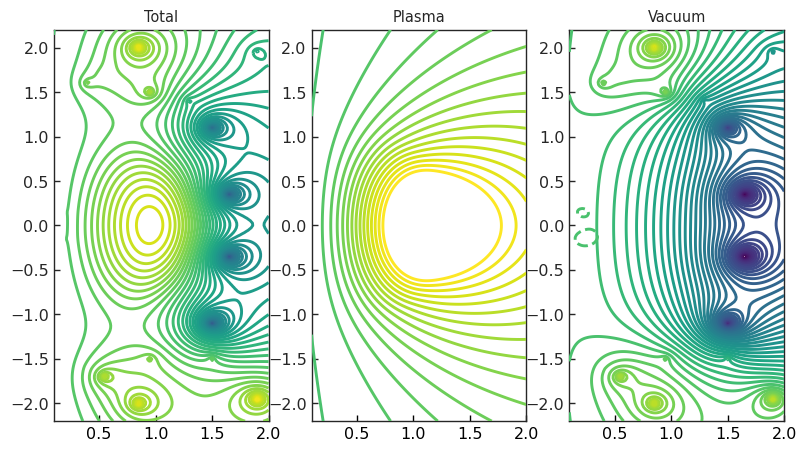

In [8]:
# Poloidal magnetic flux
total_psi = eq.psi()

# Psi contibution from the plasma
plasma_psi = eq.plasma.psi(grid.x, grid.z)

# Psi contribution from the coils
vacuum_psi = total_psi - plasma_psi
test = vacuum_psi

# If not using all coils in approx (have set control coils)
if len(coilset.get_control_coils().name) != len(coilset.name):
    # Calculate psi contributuion from non-control coils
    # This shouldn't matter if none of the coil currents have been set
    non_ccoil_cont = coilset.psi(grid.x, grid.z) - coilset.get_control_coils().psi(
        grid.x, grid.z
    )
    # Remove contributuion from non-control coils
    vacuum_psi -= non_ccoil_cont

# Plot
x_plot = grid.x
z_plot = grid.z
nlevels = 50
levels = np.linspace(np.amin(total_psi), np.amax(total_psi), nlevels)
cmap = "viridis"
plot1 = plt.subplot2grid((3, 3), (0, 0), rowspan=2, colspan=1)
plot2 = plt.subplot2grid((3, 3), (0, 1), rowspan=2, colspan=1)
plot3 = plt.subplot2grid((3, 3), (0, 2), rowspan=2, colspan=1)
plot1.set_title("Total")
plot2.set_title("Plasma")
plot3.set_title("Vacuum")
plot1.contour(x_plot, z_plot, total_psi, levels=levels, cmap=cmap, zorder=8)
plot2.contour(x_plot, z_plot, plasma_psi, levels=levels, cmap=cmap, zorder=8)
plot3.contour(x_plot, z_plot, vacuum_psi, levels=levels, cmap=cmap, zorder=8)
plot3.contour(
    x_plot,
    z_plot,
    non_ccoil_cont,
    levels=levels,
    cmap=cmap,
    zorder=8,
    linestyles="dashed",
)
plt.show()

### Flux Function at collocation points within LCFS

The steps are as follows:


1. Select collocation points within the LCFS for the chosen eqilibium.


2. Calculate psi at the collocation points using interploation of the equilibrium vacuum psi. 


3. Construct matrix from harmonic amplitudes and fit to psi at collocation points.

#### 1. Collocation points

There are currently four options for colocation point distibution: 
- 'arc' = equispaced points on an arc of fixed radius
- 'arc_plus_extrema' = 'arc' plus the min and max points the LSFS in the x- and z-directions (4 points total)
- 'random'
- 'random_plus_extrema'

N.B., the SH degree that you calculate up to should be less than the number of collocation points. 

In the plot below the colocations points are shown as purple dots, and the LCFS is indicated by a red line. 

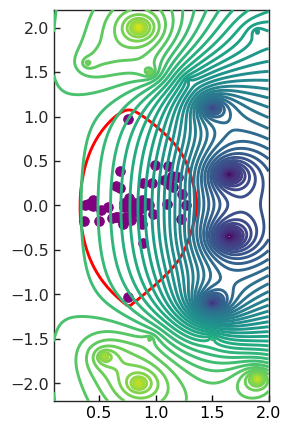

number of colocation points =  54


In [9]:
# Number of desired collocation points excluding extrema (always 4 or +4 automatically)
n = 50

# Create the set of collocation points for the harmonics
(
    collocation_r,
    collocation_theta,
    collocation_x,
    collocation_z,
    n_collocation,
) = collocation_points(
    n,
    # x_bdry,
    # z_bdry,
    original_LCFS,
    "random_plus_extrema",
)

# Plot

x_plot = grid.x
z_plot = grid.z
nlevels = 50
levels = np.linspace(np.amin(total_psi), np.amax(total_psi), nlevels)
cmap = "viridis"
plot1 = plt.subplot2grid((3, 3), (0, 0), rowspan=2, colspan=1)
plot1.contour(x_plot, z_plot, vacuum_psi, levels=levels, cmap=cmap, zorder=8)
plot1.scatter(collocation_x, collocation_z, color="purple")
plot1.plot(x_bdry, z_bdry, color="red")
plt.show()
print("number of colocation points = ", n_collocation)

#### 2. Flux function at collocation points 
N.B. linear interpolation is default.

In [10]:
# Set up with gridded values from chosen equilibirum
psi_func = RectBivariateSpline(eq.grid.x[:, 0], eq.grid.z[0, :], vacuum_psi)

# Evaluate at collocation points
collocation_psivac = psi_func.ev(collocation_x, collocation_z)

#### 3. Construct and fit harmonic amplitudes matrix

Construct matrix from harmonic amplitudes called 'harmonics2collocation' (rows = collocation, columns = degrees). 

For each collocation point (r, $\theta$) and degree calculate the following: 

$$ A_{l} = \frac{ r_{colocation}^{(l+1)} }{ r_{typical}^{l} }\frac{ P^{1}_{l}cos(\theta) }{ \sqrt(l(l+1)) } $$

Fit to psi at collocation points using np.linalg.lstsq(). This function uses least-squares to find the vector x that approximately solves the equation a @ x = b. Where 'a' is our coeffcient matrix 'harmonics2collocation', and 'b' is our depentant variable, a.k.a, the psi values at the collocation points foumd by interpolation 'collocation_psivac'. 

Result is 'psi_harmonic_ampltidues', a.k.a., the coeffcients nessisary to represent the vaccum psi using a sum of harmonics up to the selected degree. 

In [11]:
# Typical lengthscale
r_t = np.amax(x_bdry)

# Maximum degree of harmonic to calculate up to
# This value is equal to n_collocation-1 in the SHapproximation class.
max_degree = n_collocation - 1

# Construct matrix from harmonic amplitudes for flux function at collocation points
harmonics2collocation = harmonic_amplitude_marix(
    collocation_r, collocation_theta, n_collocation, max_degree, r_t
)

# Fit harmonics to match values at collocation points
psi_harmonic_ampltidues, residual, rank, s = np.linalg.lstsq(
    harmonics2collocation, collocation_psivac, rcond=None
)

### Selecting the required degrees for the approximation 

Choose the maximum number of degrees to calculate up to in order to acheive a aaproprite SH aprroximation. Below we set plot_max_degree = 4 as a test. You can cahnge the number to see what will happen to the plotted results. 

In the next section, we will caculate a metric that can be used to find an approriate number of degrees to use.

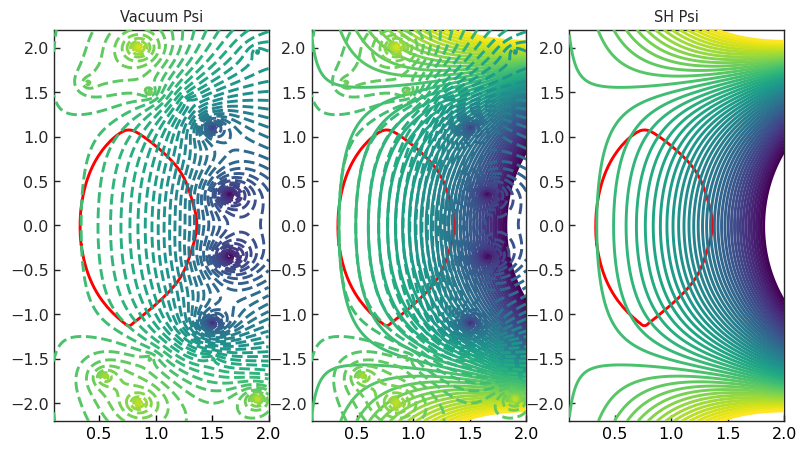

In [12]:
# Select the maximum degree to use in the approximation
plot_max_degree = 4
if plot_max_degree > max_degree:
    print("You are trying to plot more degrees then you calculated.")

# Spherical Coords
r = np.sqrt(eq.x**2 + eq.z**2)
theta = np.arctan2(eq.x, eq.z)

# First harmonic is constant
approx_psi_vac_data = psi_harmonic_ampltidues[0] * np.ones(np.shape(total_psi))

for degree in np.arange(1, plot_max_degree):
    approx_psi_vac_data = approx_psi_vac_data + (
        psi_harmonic_ampltidues[degree]
        * eq.x
        * (r / r_t) ** degree
        * lpmv(1, degree, np.cos(theta))
        / np.sqrt(degree * (degree + 1))
    )

# Plot
x_plot = grid.x
z_plot = grid.z
nlevels = 50
levels = np.linspace(np.amin(total_psi), np.amax(total_psi), nlevels)
cmap = "viridis"
plot1 = plt.subplot2grid((3, 3), (0, 0), rowspan=2, colspan=1)
plot2 = plt.subplot2grid((3, 3), (0, 1), rowspan=2, colspan=1)
plot3 = plt.subplot2grid((3, 3), (0, 2), rowspan=2, colspan=1)
plot1.set_title("Vacuum Psi")
plot3.set_title("SH Psi")
plot1.contour(
    x_plot, z_plot, vacuum_psi, levels=levels, cmap=cmap, zorder=8, linestyles="dashed"
)
plot1.plot(x_bdry, z_bdry, color="red")
plot2.contour(x_plot, z_plot, approx_psi_vac_data, levels=levels, cmap=cmap, zorder=8)
plot2.contour(
    x_plot, z_plot, vacuum_psi, levels=levels, cmap=cmap, zorder=8, linestyles="dashed"
)
plot2.plot(x_bdry, z_bdry, color="red")
plot3.contour(x_plot, z_plot, approx_psi_vac_data, levels=levels, cmap=cmap, zorder=8)
plot3.plot(x_bdry, z_bdry, color="red")
plt.show()

### Calculate Coil Currents and Find the Appropiate Degree to calculate up to 

psi_harmonic_ampltidues can be written as a function of the current distribution from the coils outside of the sphere that contains the LCFS. As we already have the value of these coeffcients, we can use them to calculate the coil currents. 

We can then calculate an approximate value of the vaccum psi, and compare the LCFS from our stating equilibria to the LCFS of our the equilibria calculated from our SH approximation. This will allow us to choose the maximum degree nessisary for an appropriate approximation. 

The steps are as follows:

1. Construct matrix from harmonic amplitudes and calculate the nessisary coil currents using the previously calculated 'psi_harmonic_ampltidues'. 

    - Construct matrix from harmonic amplitudes called 'currents2harmonics' (rows = degrees, columns = coils). For each coil location (r, $\theta$) and degree calculate the following: $$ A_{l} = \frac{\mu_{0}}{2} (\frac{r_{typical}}{r_{coil}})^{l} sin(\theta) \frac{ P^{1}_{l}cos(\theta) }{ \sqrt(l(l+1)) } $$
    
    - Calculate the coil currents using np.linalg.lstsq(). This function uses least-squares to find the vector x that approximately solves the equation a @ x = b. Where 'a' is our coeffcient matrix 'currents2harmonics', and 'b' is our depentant variable, a.k.a, the psi harmonic amplitides . 
    
    
2. Calculate the total value of psi, find the XZ coordinates of the associated LCFS and compare to the original LCFS. 
    
    - The fit metric we use for the LCFS comparision is as follows:
        fit metric value = total area within one but not both LCFSs / (input LCFS area + approximation LCFS area)

fit metric =  0.006236371407268292 degree required =  8


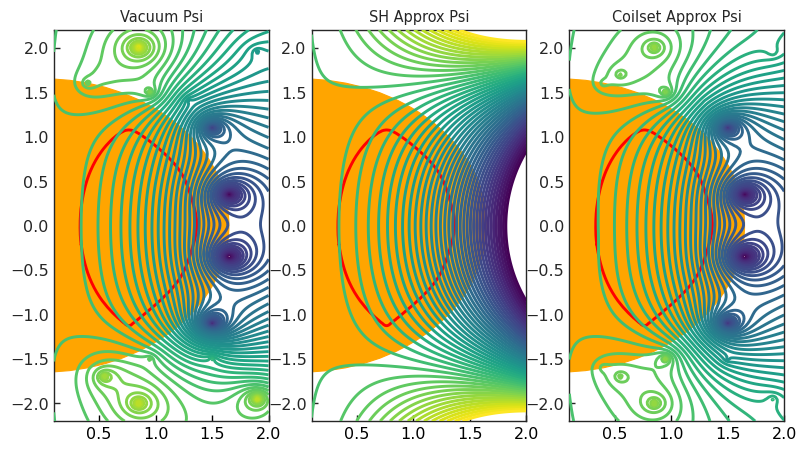

In [13]:
# Set min to save some time
min_degree = 4
# Choose acceptable value for fit metric
# 0 = good, 1 = bad
acceptable = 0.05

for degree in np.arange(min_degree, max_degree + 1):
    # Construct matrix from harmonic amplitudes for coils
    currents2harmonics, max_valid_r = coil_harmonic_amplitude_matrix(
        coilset,
        # coilset.get_control_coils().x,
        # coilset.get_control_coils().z,
        degree,
        r_t,
    )

    # Calculate necessary coil currents
    currents, residual, rank, s = np.linalg.lstsq(
        currents2harmonics[:, :], (psi_harmonic_ampltidues[:degree]), rcond=None
    )

    # Calculate the coefficients (amplitudes) of spherical harmonics for use in optimising equilibria.
    coil_current_harmonic_ampltidues = currents2harmonics[:, :] @ currents

    # Set currents in coilset
    coilset.get_control_coils().current = currents

    # Calculate the approximate Psi contribution from the coils (including the non control coils)
    coilset_approx_psi = coilset.psi(grid.x, grid.z)

    # Use in equilibrium calculation
    coilset_total_psi = coilset_approx_psi + plasma_psi
    coilset_eq = Equilibrium(coilset, grid, profiles, psi=coilset_total_psi)

    approx_LCFS = coilset_eq.get_LCFS()

    # Compare staring equlibrium to new approximate equilibrium
    fit_metric_value = lcfs_fit_metric(original_LCFS, approx_LCFS)

    if fit_metric_value < acceptable:
        print("fit metric = ", fit_metric_value, "degree required = ", degree)
        break
    elif degree == max_degree:
        print(
            "Oh no you need to use more degrees! Add some more collocation points please."
        )
        print("fit metric = ", fit_metric_value)

# Plot

x_plot = grid.x
z_plot = grid.z

nlevels = 50
levels = np.linspace(np.amin(total_psi), np.amax(total_psi), nlevels)
cmap = "viridis"

plot1 = plt.subplot2grid((3, 3), (0, 0), rowspan=2, colspan=1)
plot2 = plt.subplot2grid((3, 3), (0, 1), rowspan=2, colspan=1)
plot3 = plt.subplot2grid((3, 3), (0, 2), rowspan=2, colspan=1)

plot1.set_title("Vacuum Psi")
plot2.set_title("SH Approx Psi")
plot3.set_title("Coilset Approx Psi")

plot1.contour(x_plot, z_plot, vacuum_psi, levels=levels, cmap=cmap, zorder=8)
plot1.plot(x_bdry, z_bdry, color="red")

plot2.contour(x_plot, z_plot, approx_psi_vac_data, levels=levels, cmap=cmap, zorder=8)
plot2.plot(x_bdry, z_bdry, color="red")

plot3.contour(x_plot, z_plot, coilset_approx_psi, levels=levels, cmap=cmap, zorder=8)
plot3.plot(x_bdry, z_bdry, color="red")

plot1.set_xlim(np.min(x_plot), np.max(x_plot))
plot2.set_xlim(np.min(x_plot), np.max(x_plot))
plot3.set_xlim(np.min(x_plot), np.max(x_plot))

max_circ = patch.Circle((0, 0), max_valid_r, ec="orange", fill=True, fc="orange")
plot1.add_patch(max_circ)
max_circ = patch.Circle((0, 0), max_valid_r, ec="orange", fill=True, fc="orange")
plot2.add_patch(max_circ)
max_circ = patch.Circle((0, 0), max_valid_r, ec="orange", fill=True, fc="orange")
plot3.add_patch(max_circ)

plt.show()

### Compare the difference 

Compare the diffenece between the coilset contribution from our starting equilibria and our approximations. There should be minimal differences between the psi values inside the LCFS. The psi values outside the LCFS would be allowed to vary during optimisation. 

In the plot below, we include our original LCFS (solid red line) and the LCFS found using our approximation (dahsed blue line).

The coil current harmonic ampltidues used in the approximation can be used as constaints. 

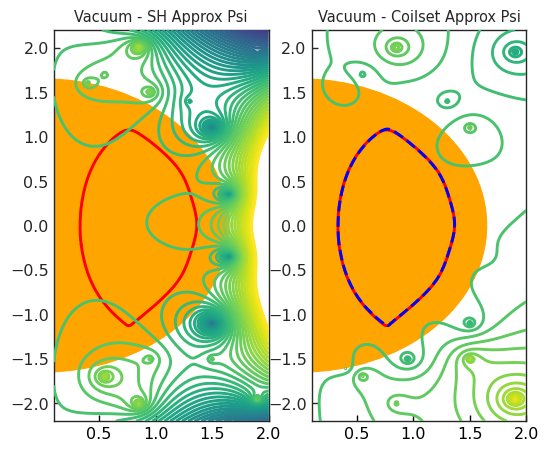

In [14]:
x_lcfs = coilset_eq.get_LCFS().x
z_lcfs = coilset_eq.get_LCFS().z

# Plot

x_plot = grid.x
z_plot = grid.z

nlevels = 50
levels = np.linspace(np.amin(total_psi), np.amax(total_psi), nlevels)
cmap = "viridis"

plot1 = plt.subplot2grid((3, 3), (0, 0), rowspan=2, colspan=1)
plot2 = plt.subplot2grid((3, 3), (0, 1), rowspan=2, colspan=1)

plot1.set_title("Vacuum - SH Approx Psi")
plot2.set_title("Vacuum - Coilset Approx Psi")

plot1.contour(
    x_plot, z_plot, vacuum_psi - approx_psi_vac_data, levels=levels, cmap=cmap, zorder=8
)
plot1.plot(x_bdry, z_bdry, color="red")

plot2.contour(
    x_plot, z_plot, vacuum_psi - coilset_approx_psi, levels=levels, cmap=cmap, zorder=8
)
plot2.plot(x_bdry, z_bdry, color="red")
plot2.plot(x_lcfs, z_lcfs, color="blue", linestyle="dashed")

plot1.set_xlim(np.min(x_plot), np.max(x_plot))
plot2.set_xlim(np.min(x_plot), np.max(x_plot))

max_circ = patch.Circle((0, 0), max_valid_r, ec="orange", fill=True, fc="orange")
plot1.add_patch(max_circ)
max_circ = patch.Circle((0, 0), max_valid_r, ec="orange", fill=True, fc="orange")
plot2.add_patch(max_circ)

plt.show()